This is a notebook that I'm using as a "final project" for Think Stats.
The idea is to try some of the stuff I learned while reading the book using some dataset.

The dataset I'm using here is **Medical Cost Personal Datasets** available at https://www.kaggle.com/mirichoi0218/insurance

In [39]:
%matplotlib inline
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from itertools import chain, combinations

In [2]:
data = pd.read_csv('./data/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# a quick overview of the data
data.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


Available fields:

    * sex (category/bool): male/female
    * bmi (numeric): body mass index computed as kg / (m^2). The expected value should be between 18.5 and 24.9.
    * children (count): number of children covered in the insurance
    * smoker (bool): does the person smoke?
    * region (category): northeast, southeast, southwest, northwest
    * charges (numeric): medical costs billed by health insurance

Some ideas from the data description:
    
    * age: min = 18 and max = 64. Mean = Median = 39
    * sex: most of the respondants are male
    * bmi: min = 15.96 and max = 53.13 (almost twice the expected value). Mean = Mean = 30
    * children: on average, one children per person. min = 0 and max = 5
    * smoker: most of the respondants are non-smokers
    * region: most of the respondants live in the southeast region

Some basic questions:
    
    * Does the region influence in costs?
    * How much does age, sex, bmi, children and smoker influence in costs?
    * Is it possible to predict the costs given some variables?

/home/julio/.conda/envs/data-analysis/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


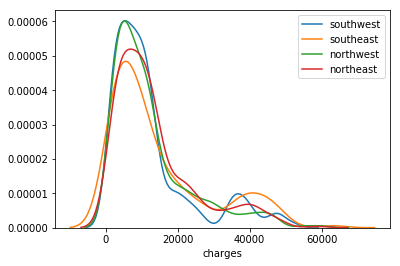

In [4]:
(fig, ax) = plt.subplots()

for region in data.region.unique():
    sns.distplot(data[data.region == region].charges, bins=15, ax=ax, hist=False, label=region)
    
plt.legend()

The above KDE estimates of the charges' distributions shows that the data is skewed to the left, around 10k, with a second peak around 35k.

All regions follow the "same" pattern.

Now, let's take a look at the Cumulative Distribution Function (CDF)

In [5]:
class Cdf(object):
    
    values = None
    probs = None
    
    def __init__(self, values):
        self.values = sorted(values)
        self.probs = self.compute_probs()
        
    def compute_probs(self):
        N = len(self.values)
        vs = self.values
        return [float(i + 1) / N for (i, _) in enumerate(vs)]

/home/julio/.conda/envs/data-analysis/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


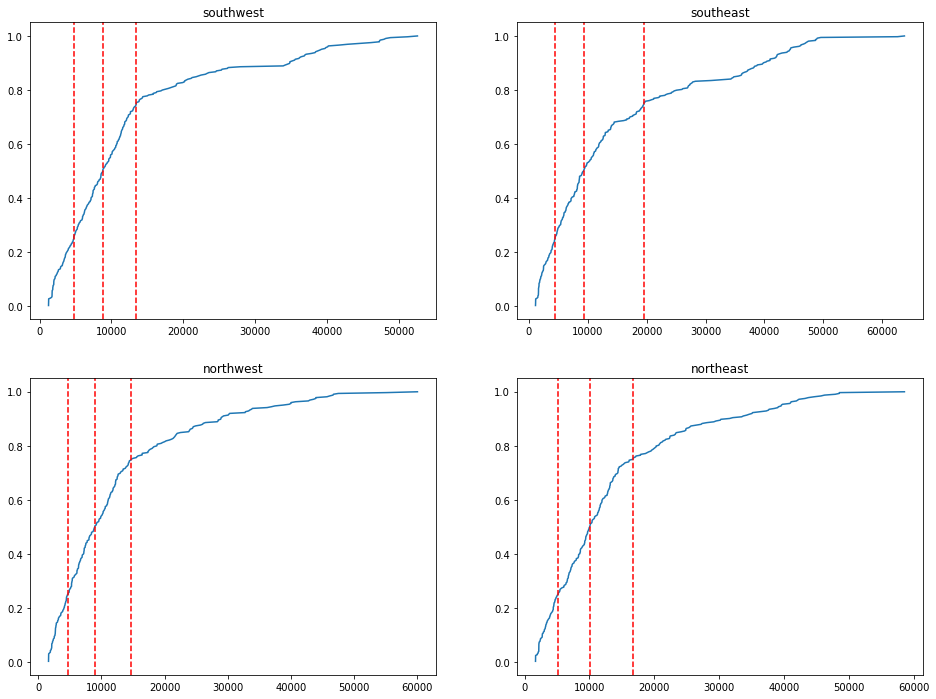

In [6]:
fig = plt.figure(figsize=(16, 12))
axes = fig.subplots(2, 2, squeeze=True)

for (ax, region) in zip(chain.from_iterable(axes), data.region.unique()):
    cdf = Cdf(data[data.region == region].charges)
    ax.set_title(region)
    ax.plot(cdf.values, cdf.probs)
    
    # plotting the 25, 50, 75 percentiles
    for perc in np.percentile(cdf.values, [25, 50, 75]):
        ax.axvline(perc, color='r', linestyle='--')
    
fig.show()

The CDFs remember a log-normal distribution, so let's try to fit a model..

A normal probability plot is used to verify if a distribution is normal.

If the resulting plot is a straight, or approximate, line, then the data is "normally" distributed.

If a distribution $x$ follows a log-normal model, then $CDF_{lognormal}(x) = CDF_{normal}(log x)$, this means
that computing the log x should result in a normal distribution.

With this in mind, we can use a normal probability plot to check for the lognormal distribution.

In [7]:
def plot_line(xs, slope, intercept, ax=None):
    ys = [x * slope + intercept for x in xs]
    ax.plot(xs, ys, color='grey', linestyle='--', label='model')
    ax.legend()

    
def normal_probability_plot(sample, ax=None):
    ax = ax if ax else plt
    sample = sorted(sample)
    
    normal = np.random.normal(0, 1, size=len(sample))
    normal = sorted(normal)
    
    plot_line(normal, np.std(sample), np.mean(sample), ax)
    
    ax.plot(normal, sample)
    ax.set_xlabel('samples from N(0, 1)')
    ax.set_ylabel('sample data')

/home/julio/.conda/envs/data-analysis/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


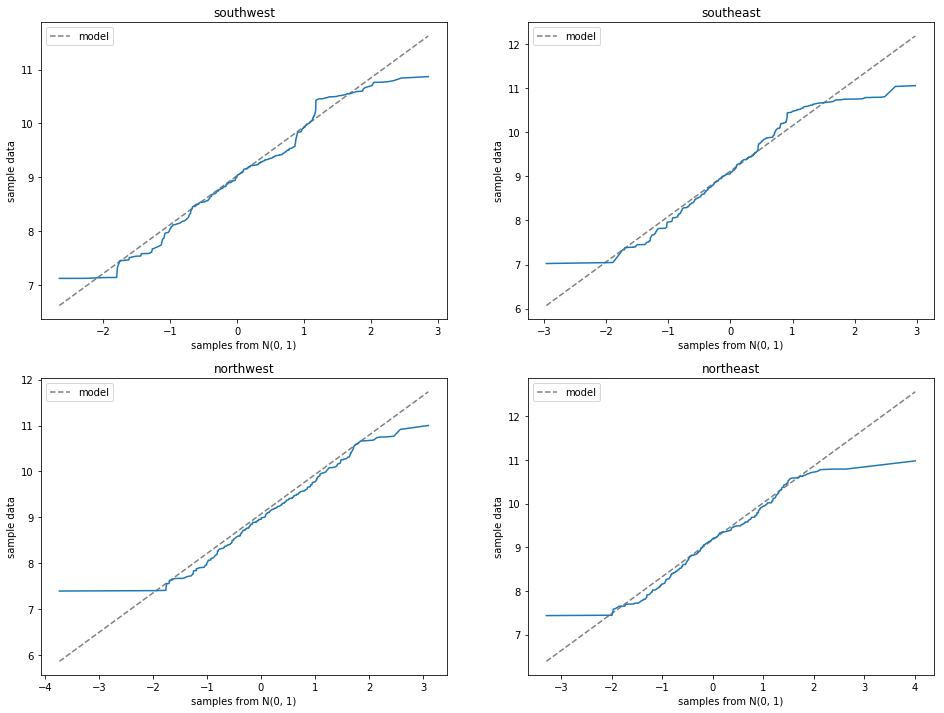

In [8]:
fig = plt.figure(figsize=(16, 12))
axes = fig.subplots(2, 2, squeeze=True)

for (ax, region) in zip(chain.from_iterable(axes), data.region.unique()):
    values = np.log(data[data.region == region].charges)
    normal_probability_plot(values, ax=ax)
    ax.set_title(region)
    
fig.show()

As we can see from the plots above, a lognormal distribution is quite efficient to describe the data.

Now that we know something about the charged values, we can try to correlate other variables to it.

In [9]:
def field_by_charges_relationship(data, field):
    fig = plt.figure(figsize=(7, 7))
    ax = fig.subplots(1, 1)

    ax.scatter(data[field], data.charges)
    ax.set_title(f'{field} x charges')
    ax.set_xlabel(field)
    ax.set_ylabel('charges')

    fig.show()

/home/julio/.conda/envs/data-analysis/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


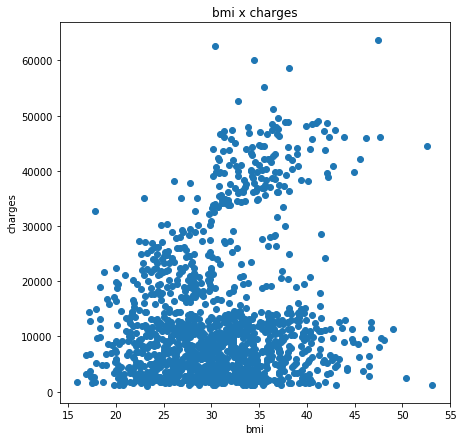

In [10]:
field_by_charges_relationship(data, 'bmi')

Although there is no direct correlation, it seems that there are 2 clusters of "bmi x charges"

In [11]:
c1 = data[data.charges > 30000]
c2 = data[data.charges <= 30000]

print('How many pay more than $30,000?', len(c1))
print('How many pay less than $30,000?', len(c2))

How many pay more than $30,000? 162
How many pay less than $30,000? 1176


In [12]:
c1.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,162.000000,162,162.000000,162.000000,162,162,162.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,yes,southeast,NaN
freq,NaN,103,NaN,NaN,152,61,NaN
mean,40.376543,NaN,34.845432,1.166667,NaN,NaN,40761.308558
std,14.472512,NaN,4.736925,1.137994,NaN,NaN,6165.955587
min,18.000000,NaN,17.765000,0.000000,NaN,NaN,30063.580550
25%,27.000000,NaN,31.692500,0.000000,NaN,NaN,36203.125612
50%,42.000000,NaN,34.650000,1.000000,NaN,NaN,39854.111650
75%,52.750000,NaN,37.027500,2.000000,NaN,NaN,44481.999400


In [13]:
c2.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,1176.000000,1176,1176.000000,1176.000000,1176,1176,1176.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,female,NaN,NaN,no,southeast,NaN
freq,NaN,603,NaN,NaN,1054,303,NaN
mean,39.045918,NaN,30.087300,1.085034,NaN,NaN,9483.412419
std,13.989404,NaN,6.041278,1.214626,NaN,NaN,6565.954307
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,26.000000,NaN,25.786250,0.000000,NaN,NaN,4348.852338
50%,39.000000,NaN,29.700000,1.000000,NaN,NaN,8246.436950
75%,51.000000,NaN,33.888750,2.000000,NaN,NaN,12629.348375


By looking at the summaries above, it seems that the major difference in charges is the `smoker` variable.

In [14]:
c1[c1.smoker == 'no'].describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,10.000000,10,10.000000,10.000000,10,10,10.000000
unique,NaN,2,NaN,NaN,1,4,NaN
top,NaN,female,NaN,NaN,no,northwest,NaN
freq,NaN,5,NaN,NaN,10,4,NaN
mean,56.200000,NaN,31.542500,1.800000,NaN,NaN,32662.649775
std,6.214678,NaN,5.114248,1.135292,NaN,NaN,2709.908603
min,44.000000,NaN,24.700000,0.000000,NaN,NaN,30063.580550
25%,52.750000,NaN,27.248750,1.000000,NaN,NaN,30266.157405
50%,57.000000,NaN,31.532500,2.000000,NaN,NaN,31864.331940
75%,60.750000,NaN,36.345000,2.000000,NaN,NaN,34738.093900


It does make sense that, peploe paying more than $30,000, and aren't smokers, are older.

In [15]:
c2[c2.smoker == 'yes'].describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,122.000000,122,122.000000,122.000000,122,122,122.000000
unique,NaN,2,NaN,NaN,1,4,NaN
top,NaN,female,NaN,NaN,yes,northeast,NaN
freq,NaN,61,NaN,NaN,122,35,NaN
mean,37.491803,NaN,25.283443,1.098361,NaN,NaN,20533.262567
std,13.479857,NaN,3.104577,1.195099,NaN,NaN,3898.722807
min,18.000000,NaN,17.195000,0.000000,NaN,NaN,12829.455100
25%,27.000000,NaN,23.250000,0.000000,NaN,NaN,17512.324437
50%,37.000000,NaN,25.650000,1.000000,NaN,NaN,19949.102150
75%,47.750000,NaN,27.883750,2.000000,NaN,NaN,23291.107800


However, there is no obvious relationship on smokers paying < $30,000

/home/julio/.conda/envs/data-analysis/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


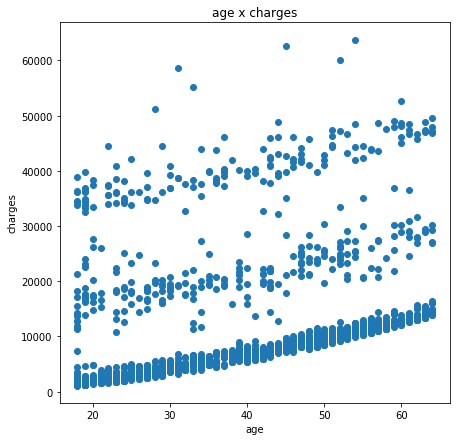

In [16]:
field_by_charges_relationship(data, 'age')

Here is the same, there is a kind of correlation upwards, but three different groups.

/home/julio/.conda/envs/data-analysis/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


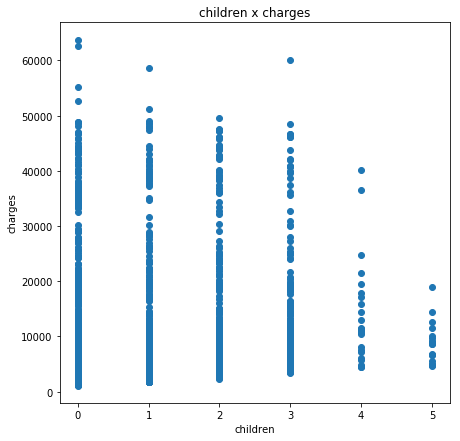

In [17]:
field_by_charges_relationship(data, 'children')

I thought, before, that more children would be correlated to higher charges. I think I was wrong.

So, it seems that the `smoker` variable plays an important role in charges.

Let's check if this hypothesis holds.

In [23]:
smokers = data[data.smoker == 'yes']['charges']
non_smokers = data[data.smoker == 'no']['charges']

print('How many smokers?', len(smokers))
print('How many non smokers?', len(non_smokers))

How many smokers? 274
How many non smokers? 1064


In [34]:
def difference_between_means(g1, g2):
    return abs(g1.mean() - g2.mean())


def permutation_sample(pool, n):
    np.random.shuffle(pool)
    return (pool[:n], pool[n:])
    

def hypothesis_test(g1, g2, statistic, alpha=0.05, n_iters=1000):
    observed = statistic(g1, g2)
    pool = np.hstack([g1, g2])
    # simulate a null hypothesis with a permutation test
    # here we assume that both groups came from the same distribution
    # so we just sample 2 random permutations
    count = 0
    for _ in range(n_iters):
        (g1, g2) = permutation_sample(pool, len(g1))
        computed = statistic(g1, g2)
        count += 1 if computed >= observed else 0
        
    p_value = float(count) / n_iters
    print('P-value:', p_value)
    print('Conclusion:', 'Alternative hypothesis' if p_value <= alpha else 'Null hypothesis')
        
    
    
hypothesis_test(smokers, non_smokers, difference_between_means)

# as we can see from the hypothesis, there is an evident difference in prices for
# smokers and non-smokers

P-value: 0.0
Conclusion: Alternative hypothesis


Now we can compute the same test for regions.

In this way, we can try to find out if there is a difference in prices per region.

In [40]:
regions = data.region.unique()

for (r1, r2) in combinations(regions, 2):
    g1 = data[data.region == r1]['charges']
    g2 = data[data.region == r2]['charges']

    print(f'How many in {r1}?', len(g1))
    print(f'How many in {r2}?', len(g2))
    
    print(f'Hypothesis test: Price for {r1} = {r2}.')
    hypothesis_test(g1, g2, difference_between_means)
    print()
    print('#########')
    print()

How many in southwest? 325
How many in southeast? 364
Hypothesis test: Price for southwest = southeast.
P-value: 0.016
Conclusion: Alternative hypothesis

#########

How many in southwest? 325
How many in northwest? 325
Hypothesis test: Price for southwest = northwest.
P-value: 0.939
Conclusion: Null hypothesis

#########

How many in southwest? 325
How many in northeast? 324
Hypothesis test: Price for southwest = northeast.
P-value: 0.238
Conclusion: Null hypothesis

#########

How many in southeast? 364
How many in northwest? 325
Hypothesis test: Price for southeast = northwest.
P-value: 0.025
Conclusion: Alternative hypothesis

#########

How many in southeast? 364
How many in northeast? 324
Hypothesis test: Price for southeast = northeast.
P-value: 0.188
Conclusion: Null hypothesis

#########

How many in northwest? 325
How many in northeast? 324
Hypothesis test: Price for northwest = northeast.
P-value: 0.289
Conclusion: Null hypothesis

#########



By the hypothesis tests above, it seems that prices only differ 
significantly between [*southeast*, *northwest*] and [*southwest*, *southeast*].